<a href="https://colab.research.google.com/github/bsaha205/Spring_23_MLO/blob/main/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Class

**Loss :**

$\mathcal{l}(Y, X) = -\frac{1}{dm} \sum_{i=1}^{d} \sum_{j=1}^{m} [x_{ij} ln(y_{ij}) + (1 - x_{ij})ln(1-y_{ij})]$

Derivative of loss, $ \frac{\partial \mathcal{l}}{\partial y_{ij}}= -\frac{1}{dm} \left[\frac{x_{ij}}{y_{ij}} - \frac{1 - x_{ij}}{1-y_{ij}}\right]$

And for other calulations, I think the python functions clearly represent those.

In [85]:
import numpy as np

class autoencoder:

    # Constructor
    def __init__(self, d, n1):
        self.d = d
        self.n1 = n1
        
        # Glorot initialization
        self.W1 = np.random.uniform(-np.sqrt(6/(d+n1)), np.sqrt(6/(d+n1)), (n1, d))
        self.b1 = np.zeros((self.n1, 1))
        self.W2 = np.random.uniform(-np.sqrt(6/(d+n1)), np.sqrt(6/(d+n1)), (d, n1))
        self.b2 = np.zeros((self.d, 1))
        
        # Adam optimizer
        self.t_step = 1
        self.nuW1 = np.zeros((n1, d))
        self.nub1 = np.zeros((n1, 1))
        self.nuW2 = np.zeros((d, n1))
        self.nub2 = np.zeros((d, 1))
        
        # Gradients and curvature information
        self.dW1 = np.zeros((n1, d))
        self.db1 = np.zeros((n1, 1))
        self.dW2 = np.zeros((d, n1))
        self.db2 = np.zeros((d, 1))

        self.hW1 = np.zeros((n1, d))
        self.hb1 = np.zeros((n1, 1))
        self.hW2 = np.zeros((d, n1))
        self.hb2 = np.zeros((d, 1))



    # Activation functions, h1 is relu and h2 is logistic sigmoid 
    def h1(self, a):
        return np.maximum(0, a)

    def h2(self, a):
        return 1 / (1 + np.exp(-a))

    
    # Derivatives of corresponding activation functions
    def dh1(self, a):
        # return np.where(a > 0, 1, 0)
        return np.maximum(np.sign(a), 0.0)
    
    def dh2(self, a):
        sigmoid = self.h2(a)           
        return sigmoid * (1 - sigmoid)

      
    # Loss function
    def loss(self, Xbatch):
        # pass through hidden and output layers
        hidden = self.h1(self.W1 @ Xbatch + self.b1)
        Ypred = self.h2(self.W2 @ hidden + self.b2)
                
        # compute and return average binary cross-entropy loss
        return - (np.sum(Xbatch * np.log(Ypred) + (1-Xbatch) * np.log(1-Ypred))) / (Xbatch.shape[0] * Xbatch.shape[1])
      
    
    # Derivative of loss function
    def dloss(self, Ybatch):
        # compute and return average derivative of loss for corresonding Xbatch stored in the autoencoder
        return - ((self.Xbatch / Ybatch) - (1-self.Xbatch) / (1-Ybatch)) / (Xbatch.shape[0] * Xbatch.shape[1])


    # Forward pass
    def forward(self, Xbatch):
        # store Xbatch and other attributes for later usuage
        self.Xbatch = Xbatch
        
        self.a1 = self.W1 @ Xbatch + self.b1
        self.o1 = self.h1(self.a1)
        
        self.a2 = self.W2 @ self.o1 + self.b2
        self.o2 = self.h2(self.a2)
                
        return self.o2


    # Backward pass
    def backward(self):
        # computing derivatives for corresponding outputs
        do2 = self.dloss(self.o2)
        da2 = self.dh2(self.a2) * do2
        do1 = self.W2.T @ da2        
        da1 = self.dh1(self.a1) * do1
        
        # storing the attributes
        self.dW1 = da1 @ self.Xbatch.T
        self.db1 = np.sum(da1)
        self.dW2 = da2 @ self.o1.T
        self.db2 = np.sum(da2)



    # Adam optimizer
    def adam_step(self, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-8):
        
        P_list = [self.W1, self.W2, self.b1, self.b2]
        nuP_list = [self.nuW1, self.nuW2, self.nub1, self.nub2]
        dP_list = [self.dW1, self.dW2, self.db1, self.db2]
        hP_list = [self.hW1, self.hW2, self.hb1, self.hb2]
        
        # updatw all attributes
        for i in range(len(P_list)):
            P = P_list[i]
            nuP = nuP_list[i]
            dP = dP_list[i]
            hP = hP_list[i]
            
            nuP[:] = rho1 * nuP + (1-rho1) * dP
            hP[:] = rho2 * hP + (1-rho2) * (dP*dP)
            
            nuPhat = nuP / (1-rho1**self.t_step)
            hPhat = hP / (1-rho2**self.t_step)
            
            P[:] = P - alpha*nuPhat / (np.sqrt(hPhat)+delta)
            
        # increment time step
        self.t_step += 1


# Train and test Fashion MNIST with the above autoencoder

## Load Fashion MNIST dataset and preprocessing

In [86]:
import torch
import torchvision
import torchvision.transforms as transforms

# transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# load Fashion MNIST dataset
train_data = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)
# convert to numpy arrays
Xtrain = np.array(train_data.data)
ytrain = np.array(train_data.targets)
Xtest = np.array(test_data.data)
ytest = np.array(test_data.targets)

# reshap and rescale to [0,1]
Xtrain = Xtrain.reshape(Xtrain.shape[0], -1) / 255 
Xtest = Xtest.reshape(Xtest.shape[0], -1) / 255 

# transpose for autoencoder input purpose
Xtrain = Xtrain.T
Xtest = Xtest.T

## Training the autoencoder

In [87]:
# initialize autoencoder
d = Xtrain.shape[0]
n1 = 100  # as mentioned
ae = autoencoder(d, n1)

# set hyper parameters
numepochs = 30
mb_size = 100
alpha = 0.005

# define ntrain and numsplits
ntrain = Xtrain.shape[1]
numsplits = ntrain / mb_size

# training
for e in range(numepochs):
    print("Training loss [%d/%d]: %.2f" % (e+1, numepochs, ae.loss(Xtrain)))
    minibatches = np.split(np.random.permutation(ntrain), numsplits)
    for indices in minibatches:
        Xbatch = Xtrain[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.adam_step(alpha=alpha)

Training loss [1/30]: 0.70
Training loss [2/30]: 0.28
Training loss [3/30]: 0.27
Training loss [4/30]: 0.27
Training loss [5/30]: 0.27
Training loss [6/30]: 0.27
Training loss [7/30]: 0.27
Training loss [8/30]: 0.27
Training loss [9/30]: 0.27
Training loss [10/30]: 0.27
Training loss [11/30]: 0.27
Training loss [12/30]: 0.27
Training loss [13/30]: 0.27
Training loss [14/30]: 0.27
Training loss [15/30]: 0.27
Training loss [16/30]: 0.27
Training loss [17/30]: 0.27
Training loss [18/30]: 0.27
Training loss [19/30]: 0.27
Training loss [20/30]: 0.27
Training loss [21/30]: 0.27
Training loss [22/30]: 0.27
Training loss [23/30]: 0.27
Training loss [24/30]: 0.27
Training loss [25/30]: 0.27
Training loss [26/30]: 0.27
Training loss [27/30]: 0.27
Training loss [28/30]: 0.27
Training loss [29/30]: 0.27
Training loss [30/30]: 0.27


## Displaying one images from each class for both original images and the corresponding reconstructed images

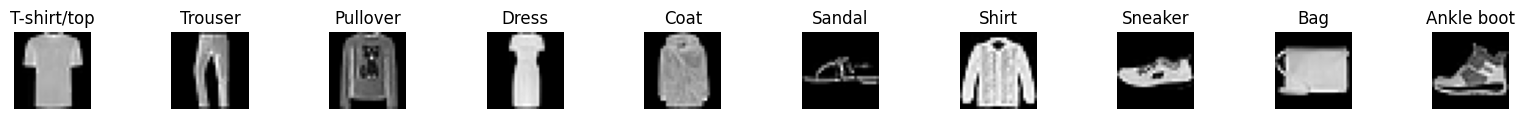

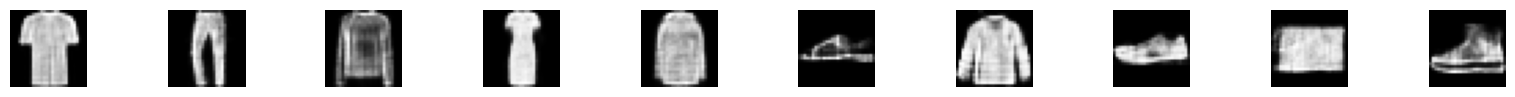

In [88]:
import matplotlib.pyplot as plt


def display_images(images, label_print=True):

    fig, ax = plt.subplots(1, 10, figsize=(20, 1))
    for i in range(len(images)):
        ax[i].imshow(images[i].reshape(28, 28), cmap='gray')
        ax[i].axis('off')
        if label_print:
          ax[i].set_title(class_names[i])
    
    plt.show()
    
    
# Define the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select one image from each class randomly from the test set
original_images = []
for i in range(10):
    original_images.append(Xtest.T[np.random.choice(np.where(ytest == i)[0])])

# display the original images
display_images(original_images)

# store reconstructed images 
reconstructed_images = []
for image in original_images:
    image_reconstructed = ae.forward(image.reshape(len(image), 1))
    reconstructed_images.append(image_reconstructed)

# display the reconstructed images
display_images(reconstructed_images, False)

# Final test loss

In [89]:
print("\nFinal Test Loss:", ae.loss(Xtest))


Final Test Loss: 0.2682472217338802


# Hyperparameters

In [91]:
print("\nBest hyperparameters that I found:\n")

print("Number of epochs:", numepochs)
print("Minibatch Size:", mb_size)
print("Learning Rate(α):", 0.005)
print("rho1:", 0.9, "  (did't change, used default value)")
print("rho2:", 0.999, "(did't change, used default value)")
print("delta:", 1e-8, "(did't change, used default value)")


Best hyperparameters that I found:

Number of epochs: 30
Minibatch Size: 100
Learning Rate(α): 0.005
rho1: 0.9   (did't change, used default value)
rho2: 0.999 (did't change, used default value)
delta: 1e-08 (did't change, used default value)


# Observations

1. Among the different batch sizes tested, a size of 70-100 performed best for me. So, I fixed it to 100 as it was comparatively faster for me.

2. When using a learning rate of 0.001, the loss rapidly decreases in the first two iterations and then reaches a plateau. After tuning, I adjusted the learning rate to 0.005.

3. The values for rho1, rho2, and delta were left unchanged as they did not have a significant impact on performance.

4. As the training progressed, the loss converged quickly and flattened out after a few epochs. After running the training for 100 epochs, I observed that the loss did not change after 10-15 epochs. Therefore, I fixed the number of epochs at 30.


5. The reconstructed images showed a high level of accuracy. While some fine details were lost, the shapes were clear enough to accurately classify the image classes.